> __Purpose:__ This NB tests a CNN in the agglomerative model clustering procedure. With later finetuning. Uses the previously developed PyTorch code

In [1]:
model_str = "CNN"
# Train/test user split: 24/8


In [2]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
import torch

np.random.seed(42) 

from moments_engr import *
from agglo_model_clust import *
from cluster_acc_viz_funcs import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *


In [3]:
path1 = 'C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\$BStand_EMG_df.pkl'

with open(path1, 'rb') as file:
    raw_userdef_data_df = pickle.load(file)  # (204800, 19)

print(raw_userdef_data_df.shape)
raw_userdef_data_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [4]:
# STEP 1: Train a classification model on every single individual user

userdef_df = raw_userdef_data_df.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)
#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
userdef_df = userdef_df.reset_index(drop=True)

#convert Gesture_ID to numerical with new Gesture_Encoded column
label_encoder = LabelEncoder()
userdef_df['Gesture_Encoded'] = label_encoder.fit_transform(userdef_df['Gesture_ID'])

label_encoder2 = LabelEncoder()
userdef_df['Cluster_ID'] = label_encoder2.fit_transform(userdef_df['Participant'])

print(userdef_df.shape)
userdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [5]:
all_participants = userdef_df['Participant'].unique()
# Shuffle the participants
np.random.shuffle(all_participants)
# Split into two groups
#train_participants = all_participants[:24]  # First 24 participants
test_participants = all_participants[24:]  # Remaining 8 participants

In [6]:
# Prepare data
data_splits = prepare_data(
    userdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=8, finetuning_trials_per_gesture=3,
)

In [7]:
data_splits.keys()

dict_keys(['train', 'intra_subject_test', 'novel_trainFT', 'cross_subject_test'])

In [8]:
data_splits['train'].keys()

dict_keys(['feature', 'labels', 'participant_ids'])

In [9]:
features_df = pd.DataFrame(data_splits['train']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
train_df['Cluster_ID'] = label_encoder.fit_transform(train_df['participant_ids'])

features_df = pd.DataFrame(data_splits['intra_subject_test']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
test_df = pd.concat([features_df, pd.Series(data_splits['intra_subject_test']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['intra_subject_test']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
test_df['Cluster_ID'] = label_encoder.fit_transform(test_df['participant_ids'])

# ENTIRELY WITHHOLDING CROSS CLUSTER DATASET (NOVEL TEST SUBJECTS) FOR NOW. 
#test_df
#features_df = pd.DataFrame(data_splits['train']['features'])
## Create a new column 'features' that contains all 80 columns as lists
#features_df['features'] = features_df.apply(lambda row: row.tolist(), axis=1)
## Keep only the new combined column
#features_df = features_df[['features']]
## Combine with labels and participant_ids into a single DataFrame
#train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)

In [10]:
data_dfs_dict = {'train':train_df, 'test':test_df}

# Need to update Cluster_ID col at the end of each round, for both dfs

In [11]:
train_df.head()

,feature,Gesture_Encoded,participant_ids,Cluster_ID
0,"[4.0728441780827485, -6.216633410388578, -15.0...",0,P128,22
1,"[4.842766138855771, -7.933026853320965, -18.38...",0,P128,22
2,"[4.343725560839635, -6.20391996380322, -15.560...",0,P128,22
3,"[4.972292120731378, -6.996600730998998, -17.60...",0,P128,22
4,"[4.942130684716379, -6.513267267205743, -16.81...",0,P128,22


In [12]:
merge_log, intra_cluster_performance, cross_cluster_performance, nested_clus_model_dict = DNN_agglo_merge_procedure(data_dfs_dict, model_str, n_splits=2)

Iter 0: 24 Clusters Remaining
Iter 1: 23 Clusters Remaining
Iter 2: 22 Clusters Remaining
Iter 3: 21 Clusters Remaining
Iter 4: 20 Clusters Remaining
Iter 5: 19 Clusters Remaining
Iter 6: 18 Clusters Remaining
Iter 7: 17 Clusters Remaining
Iter 8: 16 Clusters Remaining
Iter 9: 15 Clusters Remaining
Iter 10: 14 Clusters Remaining
Iter 11: 13 Clusters Remaining
Iter 12: 12 Clusters Remaining
Iter 13: 11 Clusters Remaining
Iter 14: 10 Clusters Remaining
Iter 15: 9 Clusters Remaining
Iter 16: 8 Clusters Remaining
Iter 17: 7 Clusters Remaining
Iter 18: 6 Clusters Remaining
Iter 19: 5 Clusters Remaining
Iter 20: 4 Clusters Remaining
Iter 21: 3 Clusters Remaining
Iter 22: 2 Clusters Remaining


In [13]:
merge_log

[(0, 1, 8, 0.35, 24),
 (1, 18, 5, 0.35, 25),
 (2, 9, 17, 0.4, 26),
 (3, 25, 2, 0.35, 27),
 (4, 6, 16, 0.3, 28),
 (5, 0, 12, 0.3, 29),
 (6, 22, 7, 0.3, 30),
 (7, 19, 26, 0.25, 31),
 (8, 28, 10, 0.3, 32),
 (9, 23, 11, 0.3, 33),
 (10, 4, 14, 0.25, 34),
 (11, 24, 15, 0.3, 35),
 (12, 33, 20, 0.25, 36),
 (13, 36, 21, 0.25, 37),
 (14, 35, 27, 0.23333333333333334, 38),
 (15, 34, 3, 0.2, 39),
 (16, 39, 30, 0.25, 40),
 (17, 40, 29, 0.2, 41),
 (18, 38, 13, 0.15, 42),
 (19, 42, 32, 0.16666666666666666, 43),
 (20, 43, 41, 0.11428571428571428, 44),
 (21, 31, 44, 0.1, 45),
 (22, 37, 45, 0.09, 46)]

## INTRA CLUSTER RESULTS

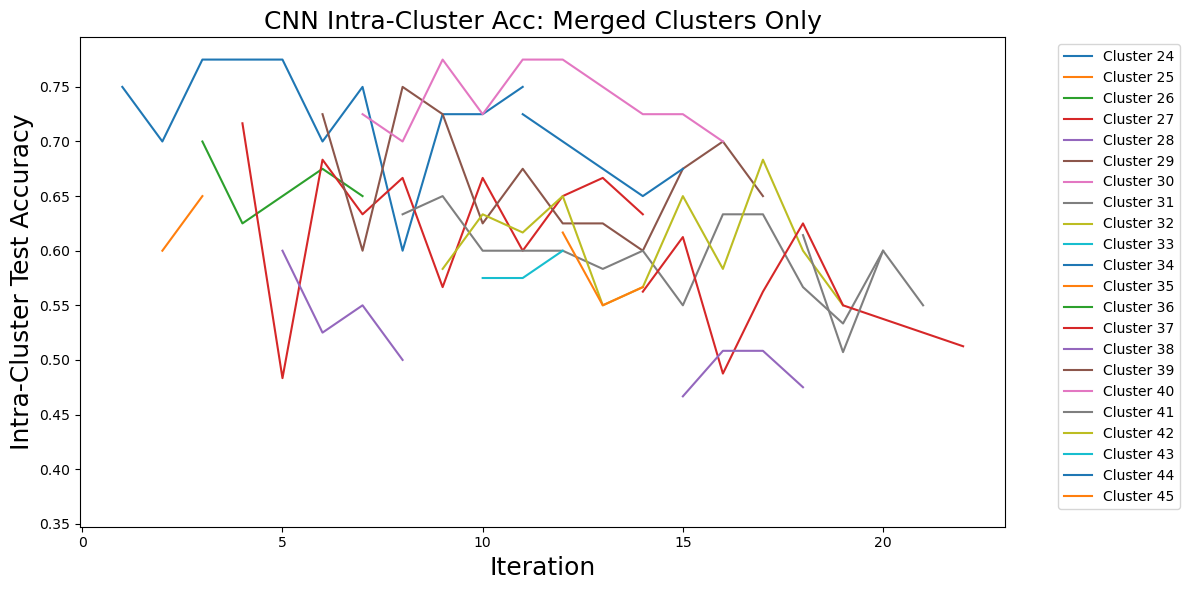

In [14]:
viz_merged_intracluster_acc(intra_cluster_performance, model_str)

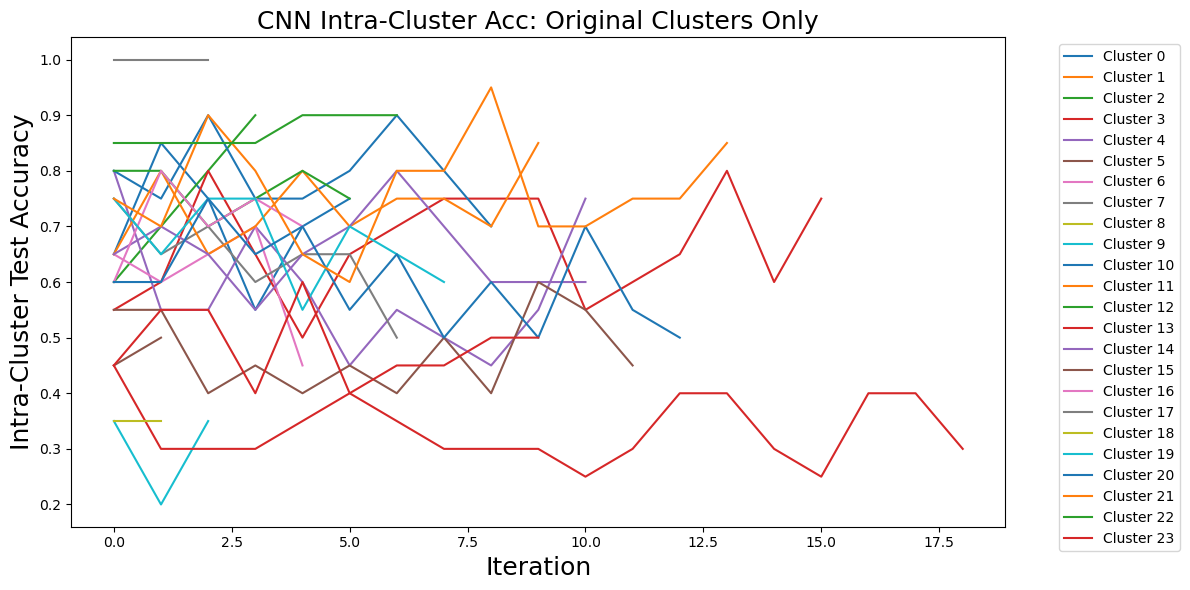

In [15]:
viz_orig_intracluster_acc(intra_cluster_performance, model_str)

## CROSS CLUSTER RESULTS

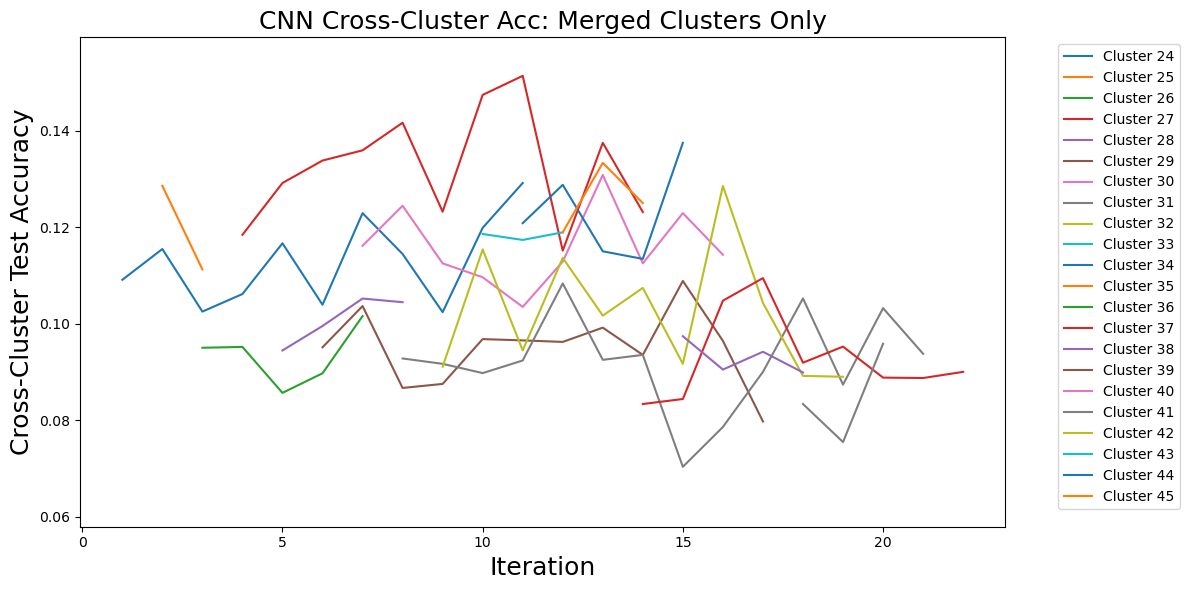

In [16]:
viz_merged_crosscluster_acc(cross_cluster_performance, model_str)

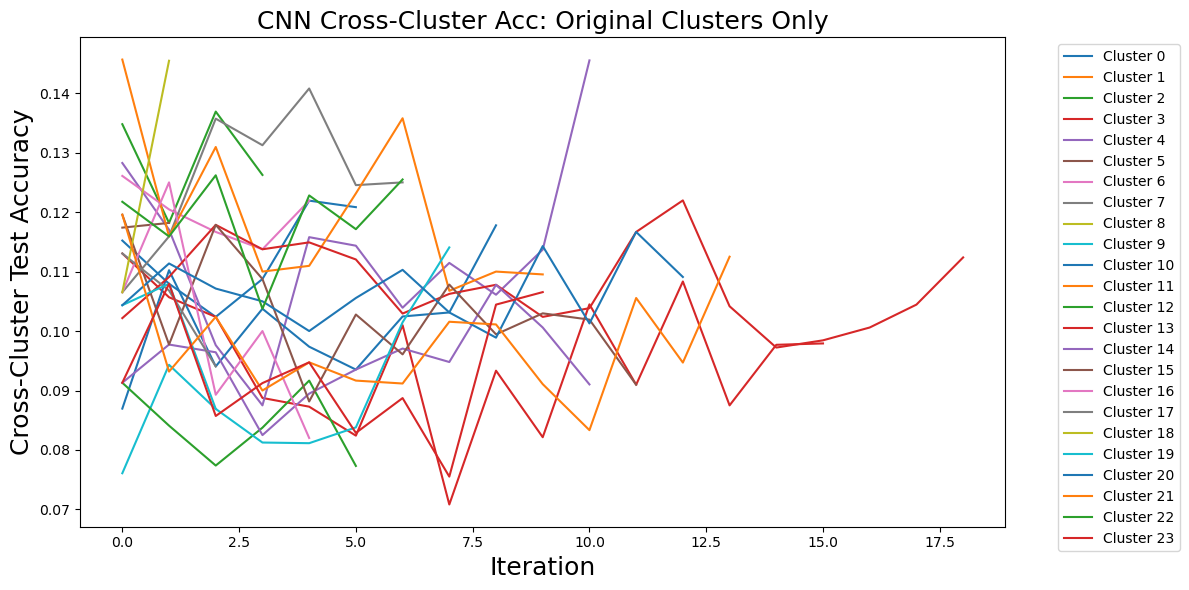

In [17]:
viz_orig_crosscluster_acc(cross_cluster_performance, model_str)

## Test Accuracy Merge Tracking

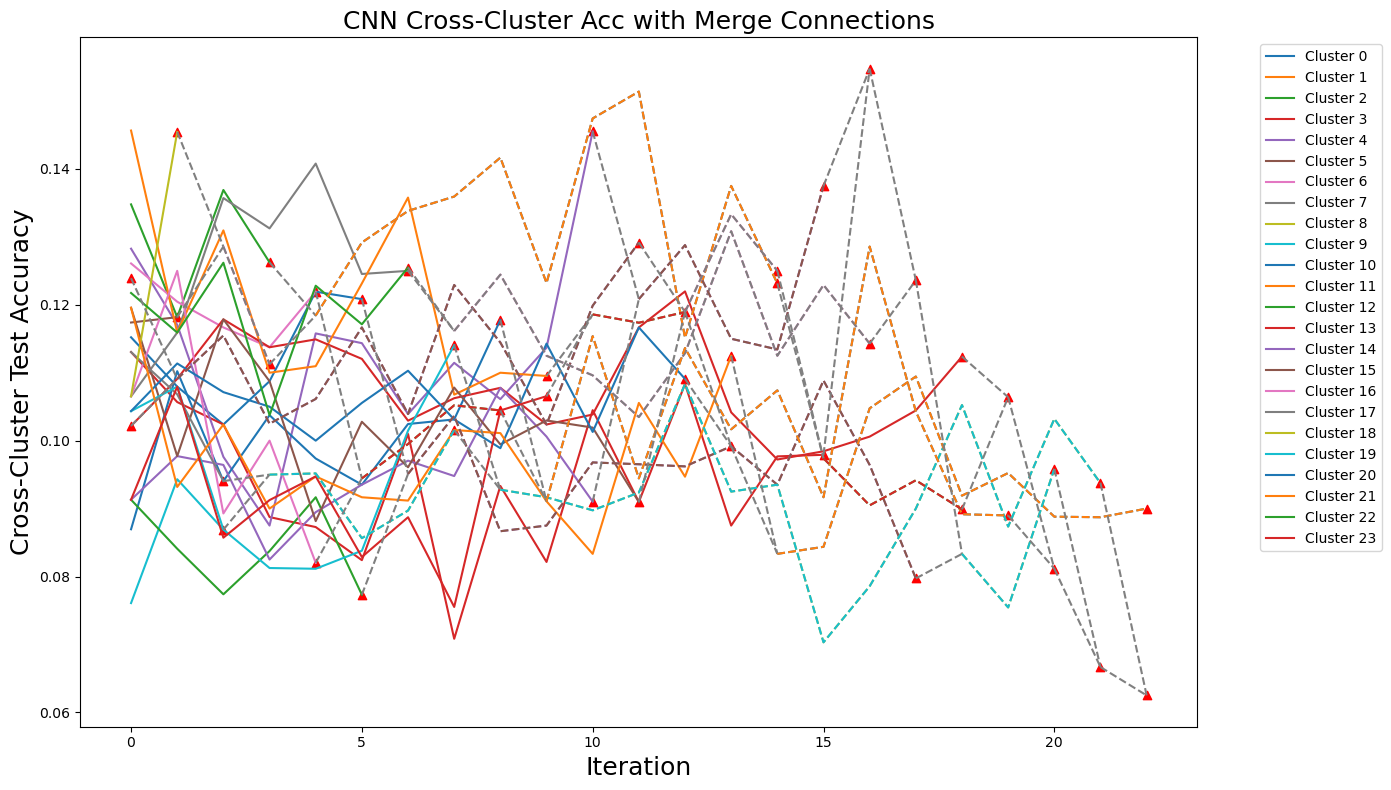

In [18]:
viz_crosscluster_acc_with_merges(cross_cluster_performance, merge_log, model_str)

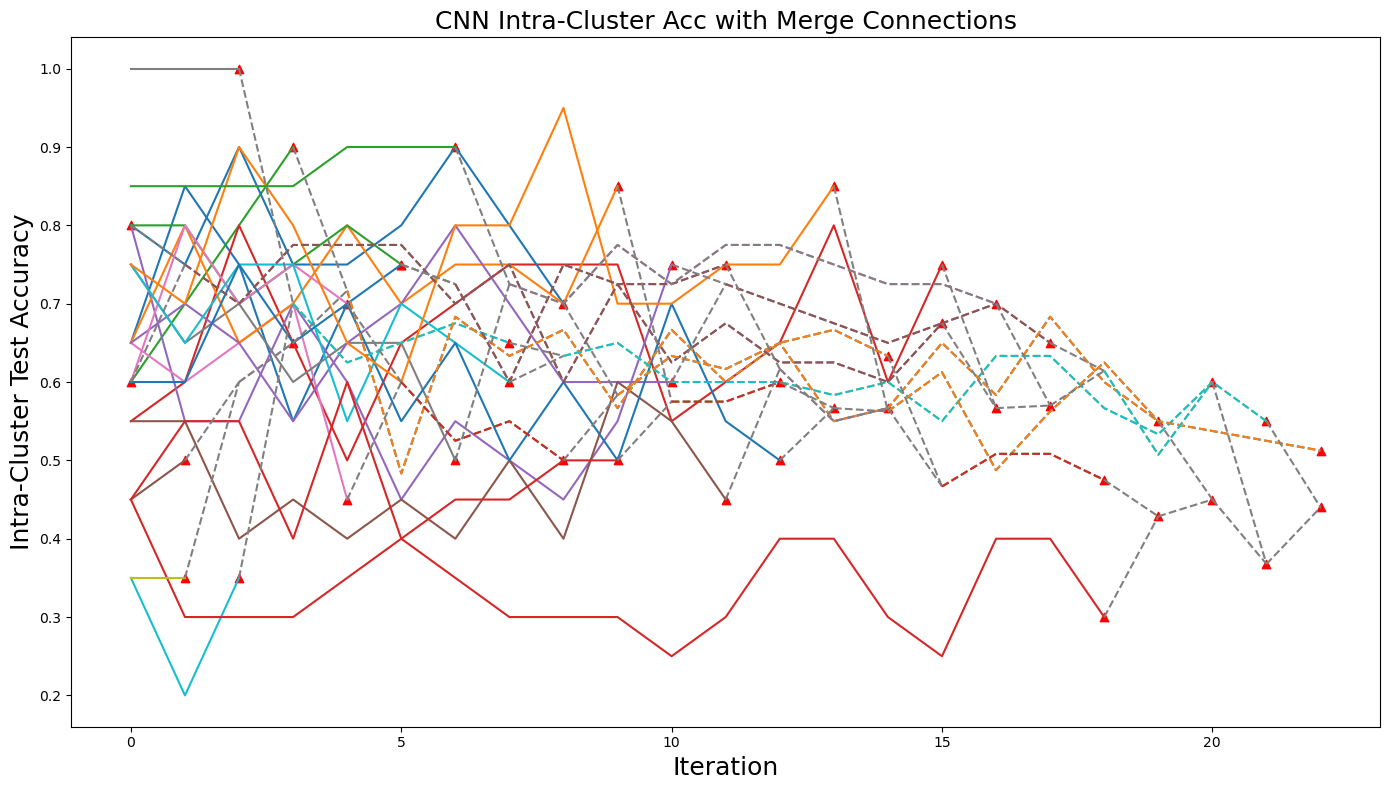

In [19]:
viz_intracluster_acc_with_merges(intra_cluster_performance, merge_log, model_str)

In [20]:
intra_mean_lst, cross_mean_lst, ratio_lst = compute_performance_ratios(intra_cluster_performance, cross_cluster_performance)



=== Performance Ratios ===
Cluster 0: Intra Mean = 0.708, Cross Mean = 0.113
Cluster 1: Intra Mean = 0.600, Cross Mean = 0.124
Cluster 2: Intra Mean = 0.750, Cross Mean = 0.129
Cluster 3: Intra Mean = 0.666, Cross Mean = 0.095
Cluster 4: Intra Mean = 0.586, Cross Mean = 0.113
Cluster 5: Intra Mean = 0.475, Cross Mean = 0.118
Cluster 6: Intra Mean = 0.610, Cross Mean = 0.120
Cluster 7: Intra Mean = 0.643, Cross Mean = 0.126
Cluster 8: Intra Mean = 0.800, Cross Mean = 0.102
Cluster 9: Intra Mean = 0.300, Cross Mean = 0.086
Cluster 10: Intra Mean = 0.794, Cross Mean = 0.101
Cluster 11: Intra Mean = 0.735, Cross Mean = 0.120
Cluster 12: Intra Mean = 0.767, Cross Mean = 0.084
Cluster 13: Intra Mean = 0.334, Cross Mean = 0.108
Cluster 14: Intra Mean = 0.655, Cross Mean = 0.095
Cluster 15: Intra Mean = 0.475, Cross Mean = 0.103
Cluster 16: Intra Mean = 0.710, Cross Mean = 0.101
Cluster 17: Intra Mean = 1.000, Cross Mean = 0.105
Cluster 18: Intra Mean = 0.350, Cross Mean = 0.126
Cluster 19: I